In [1]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs               
import cartopy.feature as cfeature         
import cartopy.util as cutil
import xarray as xr                        
import numpy as np 
import pandas as pd
import plotting_module
import xesmf as xe

In [2]:
ozone_dataset = xr.open_dataset("/glade/campaign/acom/acom-climate/UTLS/shawnh/archive/FCnudged_f09.mam.mar27.2000_2021.002/atm/proc/tseries/month_1/FCnudged_f09.mam.mar27.2000_2021.002.cam.h0.O3.200201-202412.nc")
pdeldry_dataset = xr.open_dataset("/glade/campaign/acom/acom-climate/UTLS/shawnh/archive/FCnudged_f09.mam.mar27.2000_2021.002/atm/proc/tseries/month_1/FCnudged_f09.mam.mar27.2000_2021.002.cam.h0.PDELDRY.200201-202412.nc")

In [3]:
ozone = ozone_dataset["O3"]
lat = ozone.coords['lat']
lon = ozone.coords['lon']

In [4]:
pdeldry = pdeldry_dataset['PDELDRY']

# convert to hPa from Pa
pdeldry = pdeldry.copy() / 100 

# truncate to levels 16-31
truncated_pdeldry = pdeldry.isel({pdeldry.dims[1]: slice(16, 31)})
truncated_ozone = ozone.isel({ozone.dims[1]: slice(16, 31)})

In [5]:
start_date = '2005-02-01'

truncated_pdeldry = truncated_pdeldry.sel(time=slice(start_date,'2025-01-01'))
truncated_ozone = truncated_ozone.sel(time=slice(start_date,'2025-01-01'))

In [6]:
# constants / conversion factor
NAv = 6.0221415e+23                       # molecules in mole
g = 9.81                                  # gravity
MWair = 28.94                             # g/mol
xp_const = (NAv * 10)/(MWair*g)           # scaling factor, pa to hPa and cm to m
DU_CONVERSION = 2.69 * 10**16

In [7]:
ozone_column_seasonal = xr.dot(truncated_pdeldry, xp_const*truncated_ozone, dims='lev')

In [8]:
omi_mls_ds = xr.open_dataarray("/glade/u/home/mvoncyga/SOARS_2025/OMIMLS_300hpa_monthly_mean_2005_2024_full.nc")
omi_mls_ds = omi_mls_ds.rename({'latitude': 'lat', 'longitude': 'lon'})

# shifting lon to be 0-360
omi_mls_ds['lon'] = omi_mls_ds['lon'] % 360
omi_mls_ds = omi_mls_ds.sortby('lon')

In [9]:
ozone_du_column_seasonal = ozone_column_seasonal.copy() / DU_CONVERSION

In [10]:
regridder = xe.Regridder(ozone_du_column_seasonal, omi_mls_ds, 'bilinear', periodic=True) 
ozone_du_column_seasonal_regridded = regridder(ozone_du_column_seasonal)

#ozone_du_column_seasonal_regridded = ozone_du_column_seasonal.interp(coords=dict(lat=omi_mls_ds.lat, lon=omi_mls_ds.lon), method='linear')

In [11]:
from datetime import datetime 

dataset = xr.open_dataset("tco300_omimls_oct2004_to_dec2024_1by1.nc")
ozone = dataset["TropoO3"]
cleaned_ozone_dataset = ozone.where(ozone >= 0)
dataset["TropoO3"] = cleaned_ozone_dataset

ozone = cleaned_ozone_dataset 

# adding month from attributes to coordinate
month = ozone.attrs['Month'].split(',')
first_month = month[0]                              # October 2004
last_month = month[-1].replace(' ', '')             # December 2024

start_date = datetime.strptime(first_month, "%b%Y")
end_date = datetime.strptime(last_month, "%b%Y")

time_coords = pd.date_range(start=start_date, end=end_date, freq='MS')

# renaming and assigning/removing dimensions
ozone = ozone.assign_coords(time=('months', time_coords))
ozone = ozone.rename({"time": "yearmonth",'y_elements': 'latitude', 'x_elements': 'longitude'})
ozone = ozone.swap_dims({'months': 'yearmonth'})

ozone_subsetted = ozone.sel(yearmonth=slice("2005-01-01", "2024-12-01")) ####

seasonal_omi_mls_mean = ozone_subsetted

# adding lat/lon from attributes to coordinates
lat_coords = ozone_subsetted.attrs['latitude'].split(',')
first_lat = float(lat_coords[0])
last_lat = float(lat_coords[-1])

lon_coords = ozone_subsetted.attrs['longitude'].split(',')
first_lon = float(lon_coords[0])
last_lon = float(lon_coords[-1])

lon_coords = np.arange(first_lon, 180.5, 1)
lat_coords = np.arange(first_lat,90.5, 1)

seasonal_omi_mls_mean = seasonal_omi_mls_mean.assign_coords(
    longitude=('longitude', lon_coords),
    latitude=('latitude', lat_coords)
)
seasonal_omi_mls_mean

<xarray.DataArray 'TropoO3' (yearmonth: 240, latitude: 180, longitude: 360)> Size: 62MB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * yearmonth  (yearmonth) datetime64[ns] 2kB 2005-01-01 ... 2024-12-01
  * longitude  (longitude) float64 3kB -179.5 -178.5 -177.5 ... 178.5 179.5
  * latitude   (latitude) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
Attributes:
    units:      Dobson Units
    name:       Tropo O3 Gnd-to-Tropopause
    latitude:   -89.5, -88.5, ..., 89.5
    longitude:  -179.5, -178.5, ..., 179.5
    Month:      Oct2004, Nov2004, ..., Dec2024

In [12]:
seasonal_omi_mls_mean = seasonal_omi_mls_mean.transpose('yearmonth', 'longitude', 'latitude')
ozone_du_column_seasonal_regridded = ozone_du_column_seasonal_regridded.transpose('time','lon','lat')

In [13]:
bins = np.arange(-89.5, 90.5, step=4)

binned_seasonal_omi_mls_mean = seasonal_omi_mls_mean.groupby_bins('latitude', bins).mean()
binned_seasonal_cesm_regridded = ozone_du_column_seasonal_regridded.groupby_bins('lat', bins).mean()

In [14]:
binned_monthly_omi_mls_mean = binned_seasonal_omi_mls_mean.groupby('yearmonth.month').mean('yearmonth')
binned_monthly_cesm_regridded = binned_seasonal_cesm_regridded.groupby('time.month').mean('time')

In [15]:
rmse_omi_mls = np.sqrt(((binned_monthly_omi_mls_mean - binned_monthly_omi_mls_mean.mean(axis=0))**2).mean(axis=1))
rmse_cesm = np.sqrt(((binned_monthly_cesm_regridded - binned_monthly_cesm_regridded.mean(axis=0))**2).mean(axis=1))

In [16]:
# average out by longitude
binned_monthly_omi_mls_mean = binned_monthly_omi_mls_mean.mean('longitude')
binned_monthly_cesm_regridded = binned_monthly_cesm_regridded.mean('lon')

In [17]:
latitudes = np.arange(-89.5, 84.5, step=4)

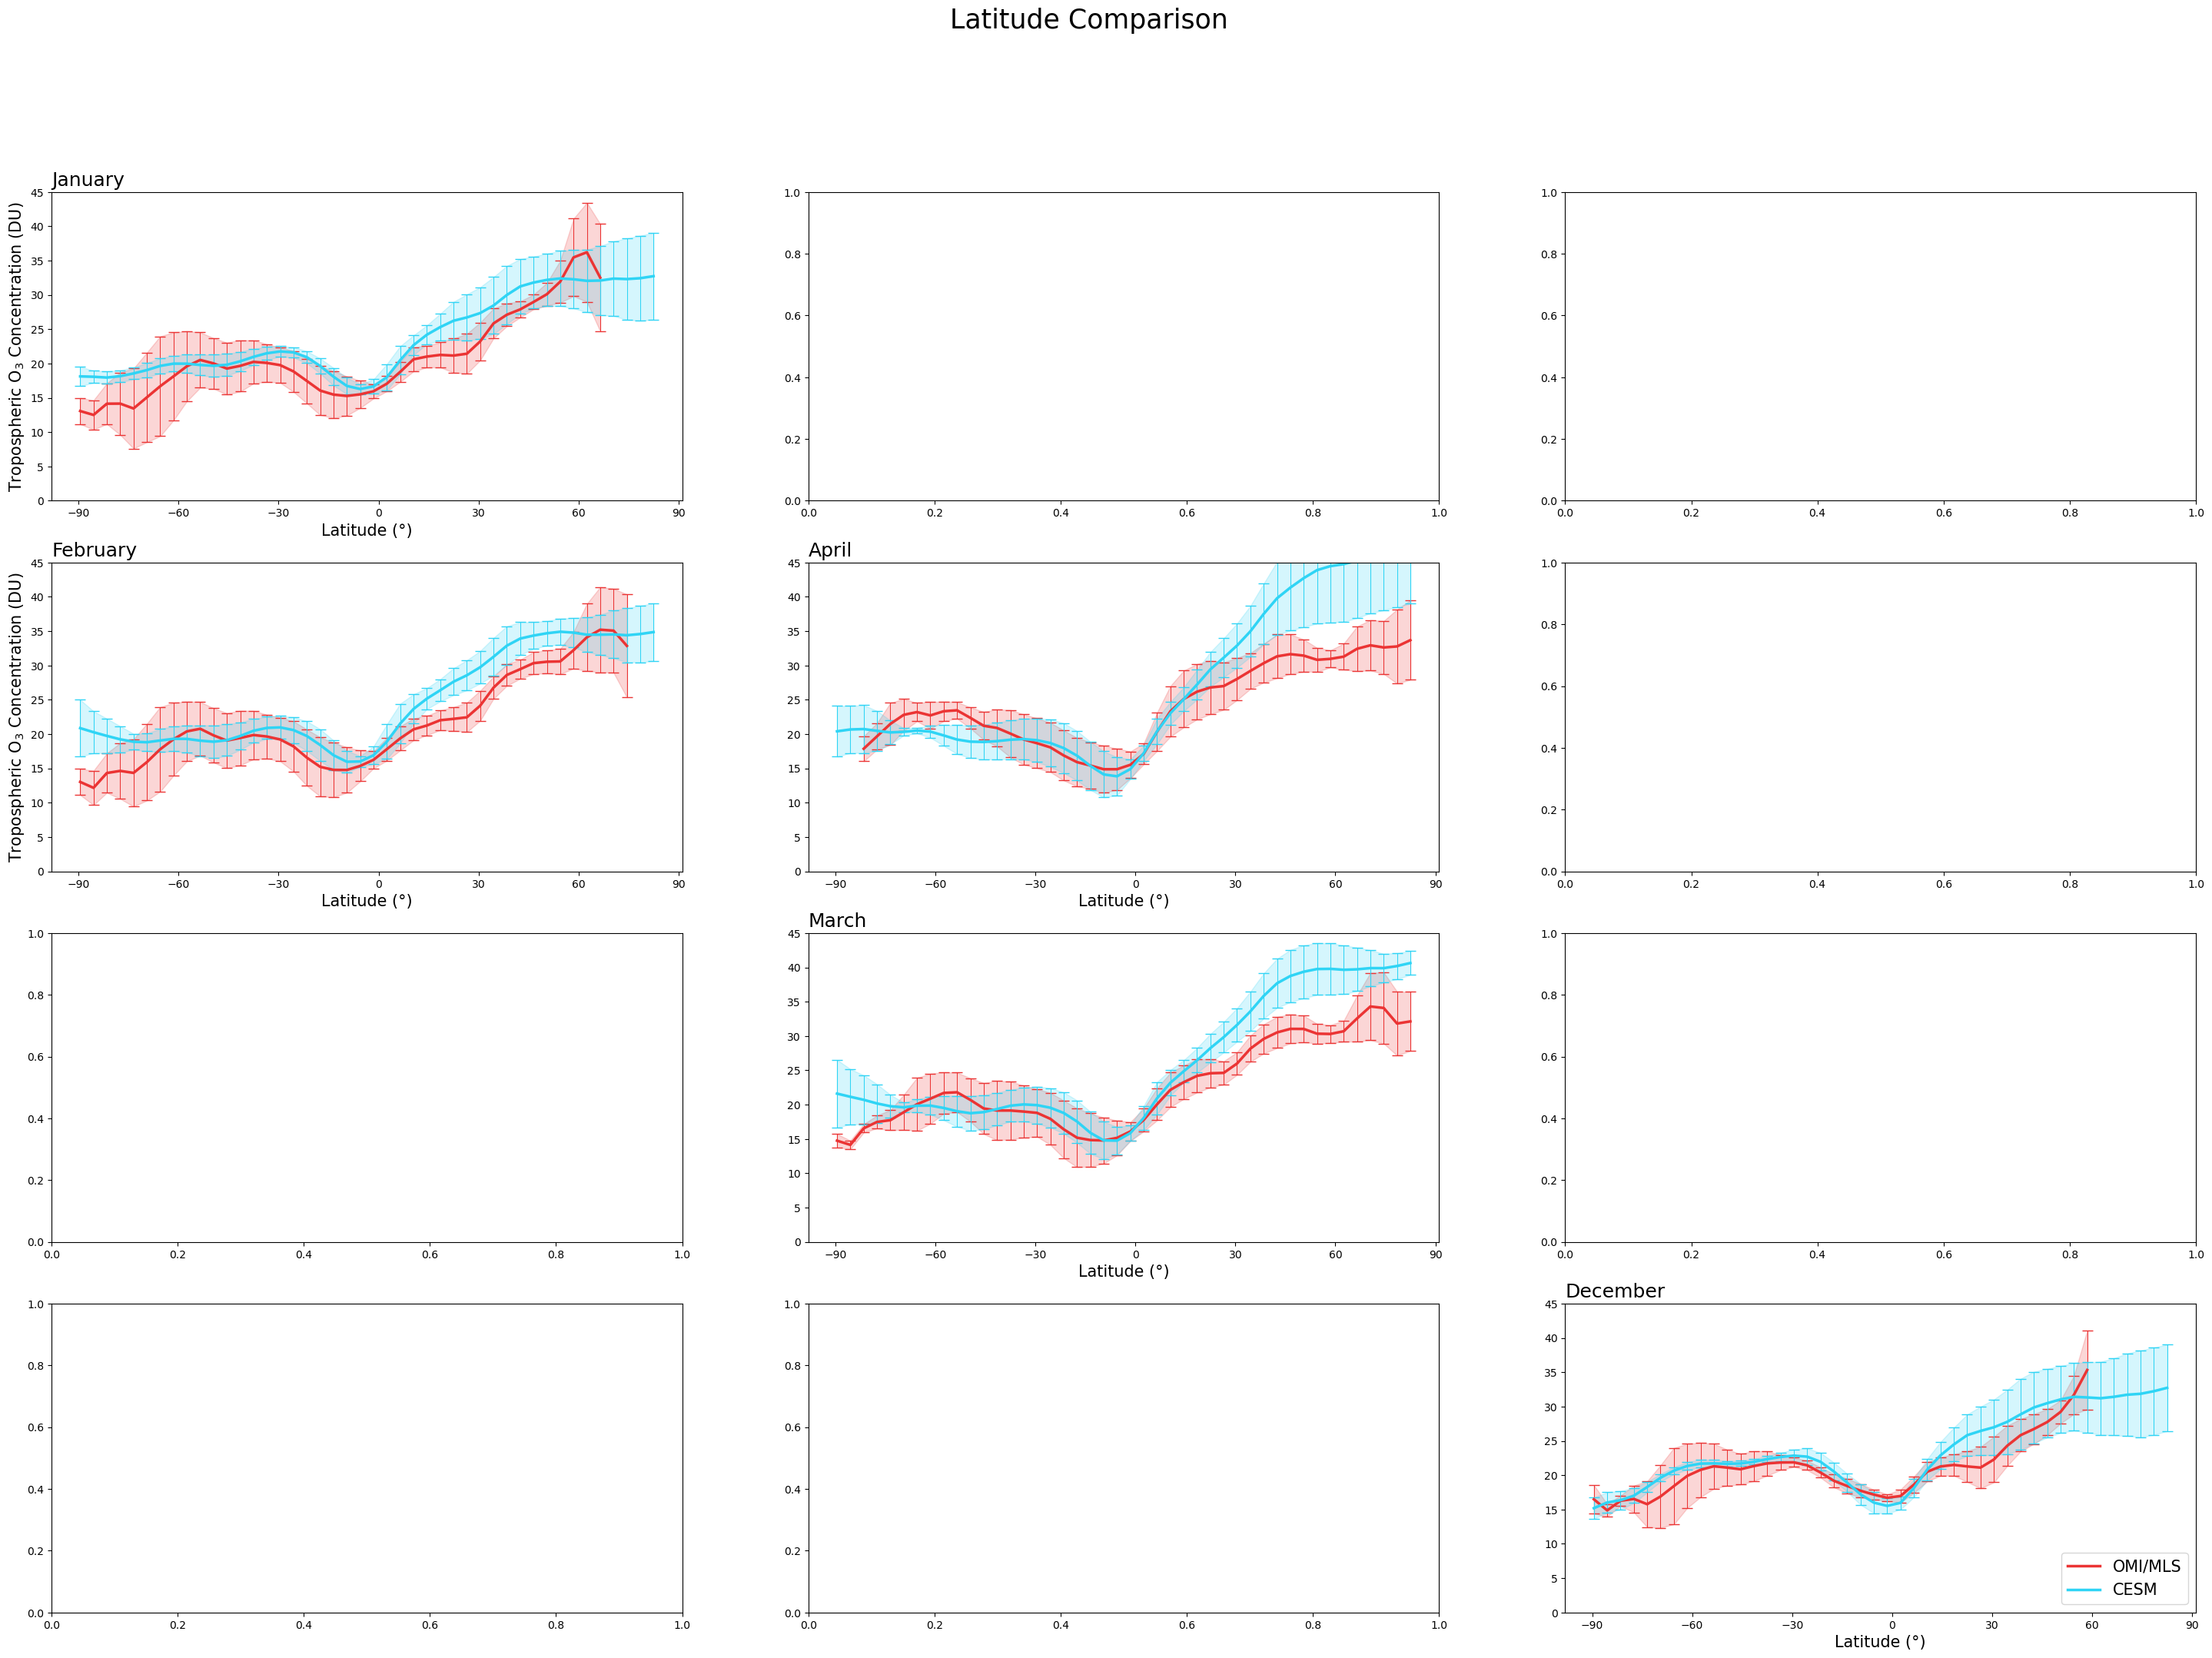

In [25]:
seasonal_list = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']


fig, ax = plt.subplots(ncols=3, nrows=4, figsize=(36,24))

i=1
ax[0][0].set_title(str(seasonal_list[0]), fontsize=18, loc='left')
ax[0][0].set_ylabel("Tropospheric $\mathregular{O_3}$ Concentration (DU)", fontsize=15)
ax[0][0].set_xlabel("Latitude (°)", fontsize=15)
ax[0][0].errorbar(latitudes, binned_monthly_omi_mls_mean[0], yerr=rmse_omi_mls[0], elinewidth=0.75, ecolor='#eb3434', fmt='none', capsize=5, errorevery=i)
ax[0][0].errorbar(latitudes, binned_monthly_cesm_regridded[0], yerr=rmse_cesm[0], elinewidth=0.75, ecolor='#2fd4f5', fmt='none', capsize=5, errorevery=i)
ax[0][0].set_ylim(0,45)
ax[0][0].plot(latitudes, binned_monthly_omi_mls_mean[0], color='#eb3434', linewidth=2.5)
ax[0][0].plot(latitudes, binned_monthly_cesm_regridded[0], color='#2fd4f5', linewidth=2.5)
ax[0][0].fill_between(latitudes, binned_monthly_omi_mls_mean[0]-rmse_omi_mls[0], binned_monthly_omi_mls_mean[0]+rmse_omi_mls[0], color='#eb3434', alpha=0.2)
ax[0][0].fill_between(latitudes, binned_monthly_cesm_regridded[0]-rmse_cesm[0], binned_monthly_cesm_regridded[0]+rmse_cesm[0], color='#2fd4f5', alpha=0.2)
ax[0][0].set_xticks([-90,-60,-30,0,30,60,90])


ax[1][0].set_title(str(seasonal_list[1]), fontsize=18, loc='left')
ax[1][0].set_ylabel("Tropospheric $\mathregular{O_3}$ Concentration (DU)", fontsize=15)
ax[1][0].set_xlabel("Latitude (°)", fontsize=15)
ax[1][0].errorbar(latitudes, binned_monthly_omi_mls_mean[1], yerr=rmse_omi_mls[1], elinewidth=0.75, ecolor='#eb3434', fmt='none', capsize=5, errorevery=i)
ax[1][0].errorbar(latitudes, binned_monthly_cesm_regridded[1], yerr=rmse_cesm[1], elinewidth=0.75, ecolor='#2fd4f5', fmt='none', capsize=5, errorevery=i)
ax[1][0].set_ylim(0,45)
ax[1][0].plot(latitudes, binned_monthly_omi_mls_mean[1], color='#eb3434', linewidth=2.5)
ax[1][0].plot(latitudes, binned_monthly_cesm_regridded[1], color='#2fd4f5', linewidth=2.5)
ax[1][0].fill_between(latitudes, binned_monthly_omi_mls_mean[1]-rmse_omi_mls[1], binned_monthly_omi_mls_mean[1]+rmse_omi_mls[1], color='#eb3434', alpha=0.2)
ax[1][0].fill_between(latitudes, binned_monthly_cesm_regridded[1]-rmse_cesm[1], binned_monthly_cesm_regridded[1]+rmse_cesm[1], color='#2fd4f5', alpha=0.2)
ax[1][0].set_xticks([-90,-60,-30,0,30,60,90])


ax[2][1].set_title(str(seasonal_list[2]), fontsize=18, loc='left')
ax[2][1].set_xlabel("Latitude (°)", fontsize=15)
ax[2][1].errorbar(latitudes, binned_monthly_omi_mls_mean[2], yerr=rmse_omi_mls[2], elinewidth=0.75, ecolor='#eb3434', fmt='none', capsize=5, errorevery=i)
ax[2][1].errorbar(latitudes, binned_monthly_cesm_regridded[2], yerr=rmse_cesm[2], elinewidth=0.75, ecolor='#2fd4f5', fmt='none', capsize=5, errorevery=i)
ax[2][1].set_ylim(0,45)
ax[2][1].plot(latitudes, binned_monthly_omi_mls_mean[2], color='#eb3434', linewidth=2.5)
ax[2][1].plot(latitudes, binned_monthly_cesm_regridded[2], color='#2fd4f5', linewidth=2.5)
ax[2][1].fill_between(latitudes, binned_monthly_omi_mls_mean[2]-rmse_omi_mls[2], binned_monthly_omi_mls_mean[2]+rmse_omi_mls[2], color='#eb3434', alpha=0.2)
ax[2][1].fill_between(latitudes, binned_monthly_cesm_regridded[2]-rmse_cesm[2], binned_monthly_cesm_regridded[2]+rmse_cesm[2], color='#2fd4f5', alpha=0.2)
ax[2][1].set_xticks([-90,-60,-30,0,30,60,90])


ax[1][1].set_title(str(seasonal_list[3]), fontsize=18, loc='left')
ax[1][1].set_xlabel("Latitude (°)", fontsize=15)
ax[1][1].errorbar(latitudes, binned_monthly_omi_mls_mean[3], yerr=rmse_omi_mls[3], elinewidth=0.75, ecolor='#eb3434', fmt='none', capsize=5, errorevery=i)
ax[1][1].errorbar(latitudes, binned_monthly_cesm_regridded[3], yerr=rmse_cesm[3], elinewidth=0.75, ecolor='#2fd4f5', fmt='none', capsize=5, errorevery=i)
ax[1][1].set_ylim(0,45)
ax[1][1].plot(latitudes, binned_monthly_omi_mls_mean[3], color='#eb3434', linewidth=2.5)
ax[1][1].plot(latitudes, binned_monthly_cesm_regridded[3], color='#2fd4f5', linewidth=2.5)
ax[1][1].fill_between(latitudes, binned_monthly_omi_mls_mean[3]-rmse_omi_mls[3], binned_monthly_omi_mls_mean[3]+rmse_omi_mls[3], color='#eb3434', alpha=0.2)
ax[1][1].fill_between(latitudes, binned_monthly_cesm_regridded[3]-rmse_cesm[3], binned_monthly_cesm_regridded[3]+rmse_cesm[3], color='#2fd4f5', alpha=0.2)
ax[1][1].set_xticks([-90,-60,-30,0,30,60,90])

ax[3][2].set_title(str(seasonal_list[11]), fontsize=18, loc='left')
ax[3][2].set_xlabel("Latitude (°)", fontsize=15)
ax[3][2].errorbar(latitudes, binned_monthly_omi_mls_mean[11], yerr=rmse_omi_mls[11], elinewidth=0.75, ecolor='#eb3434', fmt='none', capsize=5, errorevery=i)
ax[3][2].errorbar(latitudes, binned_monthly_cesm_regridded[11], yerr=rmse_cesm[11], elinewidth=0.75, ecolor='#2fd4f5', fmt='none', capsize=5, errorevery=i)
ax[3][2].set_ylim(0,45)
ax[3][2].plot(latitudes, binned_monthly_omi_mls_mean[11], color='#eb3434', linewidth=2.5)
ax[3][2].plot(latitudes, binned_monthly_cesm_regridded[11], color='#2fd4f5', linewidth=2.5)
ax[3][2].fill_between(latitudes, binned_monthly_omi_mls_mean[11]-rmse_omi_mls[11], binned_monthly_omi_mls_mean[11]+rmse_omi_mls[11], color='#eb3434', alpha=0.2)
ax[3][2].fill_between(latitudes, binned_monthly_cesm_regridded[11]-rmse_cesm[11], binned_monthly_cesm_regridded[11]+rmse_cesm[11], color='#2fd4f5', alpha=0.2)
ax[3][2].set_xticks([-90,-60,-30,0,30,60,90])

fig.suptitle('Latitude Comparison', fontsize=25)
plt.legend(['OMI/MLS', 'CESM'], loc='lower right', prop={'size':  15})



#plt.savefig("figures/Latitude_Comparison")
plt.show()